# Accreditation protocol

Accreditation Protocol (AP) is a protocol devised to characterize the reliability of noisy quantum devices.<br>

Given a noisy quantum device implementing a "target" quantum circuit, AP certifies an upper-bound on the variation distance between the probability distribution of the outputs returned by the device and the ideal probability distribution.
This method is based on Ferracin et al, "Accrediting outputs of noisy intermediate-scale quantum devices", https://arxiv.org/abs/1811.09709.

This notebook gives an example for how to use the ignis.characterization.accreditation module. This particular example shows how to accredit the outputs of a 4-qubit quantum circuit of depth 5. All the circuits are run using the noisy Aer simulator.

In [1]:
#Import general libraries (needed for functions)
import numpy as np
from numpy import random
import qiskit

#Import Qiskit classes
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error

#Import the accreditation functions.
from qiskit.ignis.verification.accreditation import AccreditationFitter,AccreditationCircuits


## Input to the protocol

AP can accredit the outputs of a __target circuit__ that<br>
1) Takes as input $n$ qubits in the state $|{0}>$<br>
2) Ends with single-qubit measurements in the Pauli-$Z$ basis<br>
3) Is made of $m$ "bands", each band containing a round of single-qubit gates and a round of controlled-$Z$ gates.<br>
The accreditation is made by employing __trap circuits__, circuits that can be efficiently simulated on a classical computer and that whose outputs are used to witness the correct functionality of the device.<br>

Let's now draw a target quantum circuit!
We start with a simple circuit to generate and measure 4-qubits GHZ states.

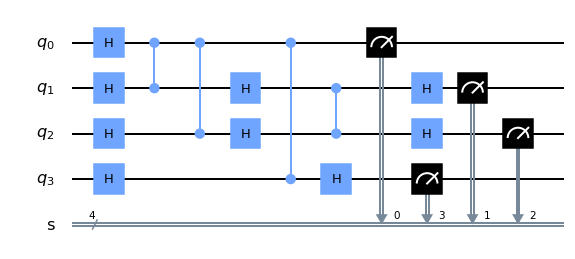

In [2]:
# Create a Quantum Register with n_qb qubits.
q_reg = QuantumRegister(4, 'q')
# Create a Classical Register with n_qb bits.
c_reg = ClassicalRegister(4, 's')
# Create a Quantum Circuit acting on the q register
target_circuit = QuantumCircuit(q_reg, c_reg)

target_circuit.h(0)
target_circuit.h(1)
target_circuit.h(2)
target_circuit.h(3)
target_circuit.cz(0,1)
target_circuit.cz(0,2)
target_circuit.h(1)
target_circuit.h(2)
target_circuit.cz(0,3)
target_circuit.cz(1,2)
target_circuit.h(1)
target_circuit.h(2)
target_circuit.h(3)

target_circuit.measure(q_reg, c_reg)

target_circuit.draw(output = 'mpl')

## Generating accreditation circuits

The function $accreditation\_circuits$ generates all the circuits required by AP, target and traps. It automatically appends random Pauli gates to the circuits (if the implementation is noisy, these random Pauli gates reduce the noise to Pauli errors ! ) <br>

It also returns the list $postp\_list$ of strings required to post-process the outputs, as well as the number $v\_zero$ indicating the circuit implementing the target.

This is the target circuit with randomly chosen Pauli gates:

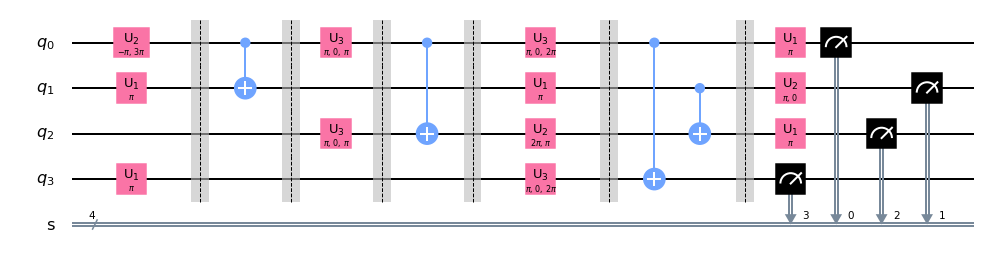

In [3]:
accsys = AccreditationCircuits(target_circuit)

v = 10

circ_list, postp_list, v_zero = accsys.generate_circuits(v)
circ_list[(v_zero)%(v+1)].draw(output = 'mpl')

This is how a trap looks like:

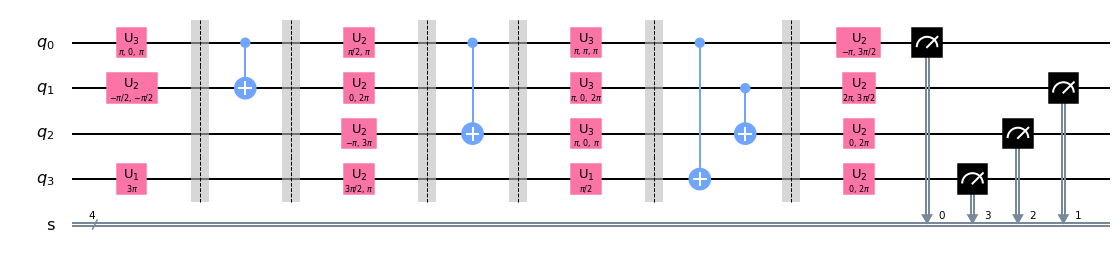

In [4]:
circ_list[(v_zero+1)%(v+1)].draw(output = 'mpl')

One can use the optional twoqubitgate argument to switch use cx instead of cz gates and can arbitrarily change the coupling map, in order to compile to the desired device topology (which in this case might lead to more layers than expected).

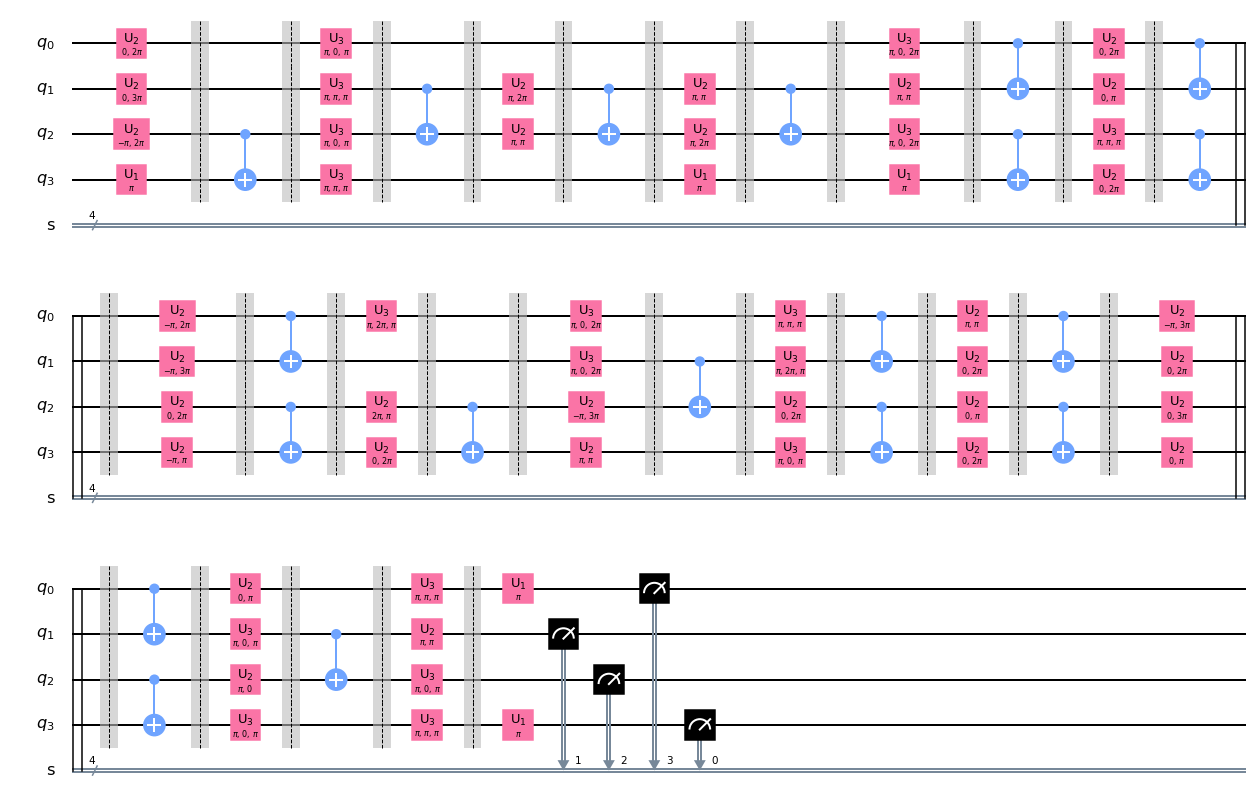

In [5]:
accsys.target_circuit(target_circuit, two_qubit_gate='cx', coupling_map=[[0,1],[1,2],[2,3]] )

v = 10

circ_list, postp_list, v_zero = accsys.generate_circuits(v)
circ_list[(v_zero)%(v+1)].draw(output = 'mpl')

## Simulate the ideal circuits

Let's implement AP.

We use $accreditation\_circuits$ to generate target and trap circuits.
Then, we use the function $single\_protocol\_run$ to implement all these circuits, keeping the output of the target only if all of the traps return the correct output.

In [6]:
simulator = qiskit.Aer.get_backend('qasm_simulator')

test_1 = AccreditationFitter()

# Create target and trap circuits with random Pauli gates
accsys = AccreditationCircuits(target_circuit)
circuit_list, postp_list, v_zero = accsys.generate_circuits(v)


job = execute(circuit_list,
              simulator,
              shots=1)
result = job.result()
# Post-process the outputs and see if the protocol accepts
test_1.single_protocol_run(result, postp_list, v_zero)

print("Outputs of the target: ",test_1.outputs," , AP",test_1.flag,"these outputs!")

Outputs of the target:  ['0100']  , AP accepted these outputs!


In the absence of noise, all traps return the expected output, therefore we always accept the output of the target.<br>

To obtain an upper-bound on the variation distance on the outputs of the target circuit, we need to implement AP $d$ times, each time with ___v___ different trap circuits.

In [7]:
# Number of runs
d = 20

test_2 = AccreditationFitter()

for run in range(d):
    
    # Create target and trap circuits with random Pauli gates
    circuit_list, postp_list, v_zero = accsys.generate_circuits(v)
    
    
    # Implement all these circuits
    
    job = execute(circuit_list,
                  simulator,
                  shots=1)
    result = job.result()

    # Post-process the outputs and see if the protocol accepts
    test_2.single_protocol_run(result, postp_list, v_zero)
    print("Protocol run number",run+1,", outputs of the target",test_2.flag)
    
print('\nAfter',test_2.num_runs,'runs, AP has accepted',test_2.N_acc,'outputs!')

print('\nList of accepted outputs:\n', test_2.outputs)

Protocol run number 1 , outputs of the target accepted
Protocol run number 2 , outputs of the target accepted
Protocol run number 3 , outputs of the target accepted
Protocol run number 4 , outputs of the target accepted
Protocol run number 5 , outputs of the target accepted
Protocol run number 6 , outputs of the target accepted
Protocol run number 7 , outputs of the target accepted
Protocol run number 8 , outputs of the target accepted
Protocol run number 9 , outputs of the target accepted
Protocol run number 10 , outputs of the target accepted
Protocol run number 11 , outputs of the target accepted
Protocol run number 12 , outputs of the target accepted
Protocol run number 13 , outputs of the target accepted
Protocol run number 14 , outputs of the target accepted
Protocol run number 15 , outputs of the target accepted
Protocol run number 16 , outputs of the target accepted
Protocol run number 17 , outputs of the target accepted
Protocol run number 18 , outputs of the target accepted
P

The function $bound\_variation\_distance$ calculates the upper-bound on the variation distance (VD) using

$$VD\leq \frac{\varepsilon}{N_{\textrm{acc}}/d-\theta}\textrm{ ,}$$

where $\theta\in[0,1]$ is a positive number and<br>

$$\varepsilon= \frac{1.7}{v+1}$$

is the maximum probability of accepting an incorrect state for the target.<br>
The function $bound\_variation\_distance$ also calculates the confidence in the bound as 

$$1-2\textrm{exp}\big(-2\theta d^2\big)$$

In [8]:
theta = 5/100

test_2.bound_variation_distance(theta)

print("AP accepted",test_2.N_acc,"out of",test_2.num_runs,"times.")
print("With confidence",test_2.confidence,"AP certifies that VD is upper-bounded by",test_2.bound)

AP accepted 20 out of 20 times.
With confidence 1.0 AP certifies that VD is upper-bounded by 0.16267942583732053


## Defining the noise model

We define a noise model for the simulator. We add depolarizing error probabilities to the controlled-$Z$ and single-qubit gates.

In [9]:
noise_model = NoiseModel()

p1q = 0.003
noise_model.add_all_qubit_quantum_error(depolarizing_error(p1q, 1), 'u1')
noise_model.add_all_qubit_quantum_error(depolarizing_error(p1q, 1), 'u2')
noise_model.add_all_qubit_quantum_error(depolarizing_error(p1q, 1), 'u3')
p2q = 0.03
noise_model.add_all_qubit_quantum_error(depolarizing_error(p2q, 2), 'cx')

basis_gates = ['u1','u2','u3','cx']

We then implement noisy circuits and pass their outputs to $single\_protocol\_run$.

In [10]:
test_3 = AccreditationFitter()

for run in range(d):
    
    # Create target and trap circuits with random Pauli gates
    circuit_list, postp_list, v_zero = accsys.generate_circuits(v)
    job = execute(circuit_list,
                  simulator,
                  noise_model=noise_model,
                  basis_gates=basis_gates,
                  shots=1,
                  backend_options={'max_parallel_experiments': 0})
    result = job.result()
    # Post-process the outputs and see if the protocol accepts
    test_3.single_protocol_run(result, postp_list, v_zero)
    print("Protocol run number",run+1,", outputs of the target",test_3.flag)
  
print("\nAP accepted",test_3.N_acc,"out of",test_3.num_runs,"times.")
print('\nList of accepted outputs:\n', test_3.outputs)

theta = 5/100

test_3.bound_variation_distance(theta)
print("\nWith confidence",test_3.confidence,"AP certifies that VD is upper-bounded by",test_3.bound)

Protocol run number 1 , outputs of the target rejected
Protocol run number 2 , outputs of the target rejected
Protocol run number 3 , outputs of the target rejected
Protocol run number 4 , outputs of the target rejected
Protocol run number 5 , outputs of the target rejected
Protocol run number 6 , outputs of the target rejected
Protocol run number 7 , outputs of the target accepted
Protocol run number 8 , outputs of the target rejected
Protocol run number 9 , outputs of the target accepted
Protocol run number 10 , outputs of the target rejected
Protocol run number 11 , outputs of the target rejected
Protocol run number 12 , outputs of the target rejected
Protocol run number 13 , outputs of the target accepted
Protocol run number 14 , outputs of the target rejected
Protocol run number 15 , outputs of the target rejected
Protocol run number 16 , outputs of the target rejected
Protocol run number 17 , outputs of the target rejected
Protocol run number 18 , outputs of the target accepted
P

Changing the number of trap circuits per protocol run changes the upper-bound on the VD, but not the confidence.<br>

What number of trap circuits will ensure the minimal upper-bound for your target circuit?

In [11]:
min_traps = 4
max_traps = 10


for num_trap_circs in range(min_traps,max_traps): 
    
    test_4 = AccreditationFitter()
    for run in range(d):

        # Create target and trap circuits with random Pauli gates
        circuit_list, postp_list, v_zero = accsys.generate_circuits(num_trap_circs)

        job = execute(circuit_list,
                      simulator,
                      noise_model=noise_model,
                      basis_gates=basis_gates,
                      shots=1,
                      backend_options={'max_parallel_experiments': 0})
        result = job.result()

        # Post-process the outputs and see if the protocol accepts
        test_4.single_protocol_run(result, postp_list, v_zero)

    print("\nWith", num_trap_circs,
          "traps, AP accepted", test_4.N_acc,              
          "out of", test_4.num_runs, "times.")
    test_4.bound_variation_distance(theta)
    print("With confidence", test_4.confidence,
          "AP with", num_trap_circs,
          "traps certifies that VD is upper-bounded by", test_4.bound)


With 4 traps, AP accepted 16 out of 20 times.
With confidence 1.0 AP with 4 traps certifies that VD is upper-bounded by 0.45333333333333337

With 5 traps, AP accepted 7 out of 20 times.
With confidence 1.0 AP with 5 traps certifies that VD is upper-bounded by 0.9444444444444444

With 6 traps, AP accepted 11 out of 20 times.
With confidence 1.0 AP with 6 traps certifies that VD is upper-bounded by 0.48571428571428577

With 7 traps, AP accepted 9 out of 20 times.
With confidence 1.0 AP with 7 traps certifies that VD is upper-bounded by 0.53125

With 8 traps, AP accepted 7 out of 20 times.
With confidence 1.0 AP with 8 traps certifies that VD is upper-bounded by 0.6296296296296298

With 9 traps, AP accepted 11 out of 20 times.
With confidence 1.0 AP with 9 traps certifies that VD is upper-bounded by 0.33999999999999986
